In [6]:
from scipy.stats import multivariate_normal
import pybnb
from functools import partial
from sklearn.ensemble import IsolationForest

%load_ext autoreload
%autoreload 2

from BranchAndBoundSolver import BranchAndBoundSolver, BranchAndBoundTopDown, BranchAndBoundBottomUp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
training_points = multivariate_normal.rvs(size=(6,2))
point_to_be_classified = training_points[0]

In [14]:
problem = BranchAndBoundBottomUp(training_points, point_to_be_classified, 0.1)
solver = pybnb.Solver(comm=None)
results = solver.solve(problem, absolute_gap=0.1)

pattern [[[-0.35382273 -0.68627745]
  [-0.35382273 -0.68627745]]

 [[-2.04316666 -1.02841483]
  [-0.35382273 -0.68627745]]]
move=counter [[0 0]
 [3 0]]

Using non-default solver options:
 - absolute_gap: 0.1 (default: 0)

Starting branch & bound solve:
 - dispatcher pid: 59386 (MacBook-Pro-2.local)
 - worker processes: 1
---------------------------------------------------------------------------------------------------------------------
         Nodes        |                   Objective Bounds                     |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap    Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%        inf |      0.0       0.00     0.00%      0
         1         0  |            inf             inf    0.000000%          0 |      0.0     671.52     0.00%      0
--------------------------------------------------------------------------------------------

In [133]:
problem.counter_counter

366354

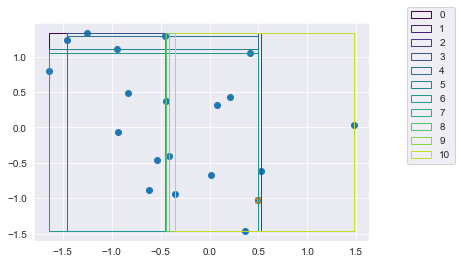

In [134]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
cmap = plt.colormaps['viridis']
def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=index
    )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x")
ax = plt.gca()
total = len(problem.trajectory)
for i, interval in enumerate(problem.trajectory):
    draw2dpattern(interval, ax, i, total)
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

## Implementing PAC-RPAD algorithm.

In [7]:
from typing import Callable
import numpy as np
from patterns import AxisAlignedHyperRectangle, find_bounding_pattern

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat: Callable[[np.ndarray], float] = lambda *_: 0. #this function should be provided by each subclass based on training data

    def has_rare_pattern(self, point) -> bool:
        return self.find_min_f_hat(point) <= self.tau + self.epsilon / 2

In [74]:

class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None

    def construct_f_hat_estimator(self, training_data, absolute_gap=0.01, queue_strategy="bound"):
        self.solver = partial(BranchAndBoundSolver, training_data = training_data)
        self.find_min_f_hat = lambda point: pybnb.Solver(comm=None).solve(self.solver(point_to_be_classified = point),
                                                                             absolute_gap=absolute_gap,
                                                                             queue_strategy=queue_strategy
                                                                             ).objective

class RandomForestApproximatePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.random_forest = None

    def construct_f_hat_estimator(self, training_data, n_estimators=100):
        self.random_forest = IsolationForest(random_state=0, n_estimators=n_estimators).fit(training_data)
        bounding_pattern = find_bounding_pattern(training_data)

        def find_pattern_in_tree(tree, point:np.array):
            features = tree.feature
            thresholds = tree.threshold
            intervals = bounding_pattern.intervals

            point = point.astype(np.float32).reshape(1,-1)
            node_index = list(tree.decision_path(point).indices)
            #going through the non-leaf nodes to and updating threshold along the way:
            while len(node_index) > 1:
                node_id = node_index.pop()
                f = features[node_id]
                t = thresholds[node_id]
                intervals[point[f] > t,f] = t
            # the output of this function is the numper of samples in the pattern, together with the rectangle
            return tree.n_node_samples[node_index[0]], AxisAlignedHyperRectangle(intervals)

        def evaluate_f_hat(tree, point):
            samples, pattern = find_pattern_in_tree(tree, point)
            return (samples * bounding_pattern.area)/(pattern.area * len(training_data))

        self.find_min_f_hat = lambda point : min([evaluate_f_hat(estimator.tree_, point) for estimator in self.random_forest.estimators_])

In [66]:
delta = 0.1
epsilon = 0.1
tau = 0.1
exact = AxisAlignedHyperRectanglePACRPAD(tau, epsilon, delta)
exact.construct_f_hat_estimator(training_points)
exact.has_rare_pattern(training_points[0])

In [75]:
approximates = []
for est in [100, 1000, 10000]:
    approximate = RandomForestApproximatePACRPAD(tau, epsilon, delta)
    approximate.construct_f_hat_estimator(training_points, n_estimators=est)
    approximates.append(approximate)


In [ ]:
training_points = sample(100)
training_points.save_to_file()

labels = np.zeroes((len(training_points), len(approximates) + 1))
for i, point in enumerate(training_points):
    exact_solution = exact.has_rare_pattern(point)
    approx = map(lambda a: a.has_rare_pattern, approximates)
    # fill_labels

#plot_outcome
#bar plot

